In [1]:
import pandas as pd 
import joblib
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split 
from skmultilearn.problem_transform import BinaryRelevance
from xgboost import XGBClassifier



In [4]:
# loading the X, y, vectoriser

X = joblib.load("data/X.pkl")
y = joblib.load("data/y.pkl")
vectoriser = joblib.load("data/tfidf_vectoriser.pkl")


df = pd.read_csv("data/cleaned_df.csv")

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
X.text_cleaned

0       War in Afghanistan  2001 2021    2021 Afghanis...
1       Russo Ukrainian War   2022 Russian invasion of...
2       In  India   a new  income tax  law comes into ...
3       Israel Hamas war   World Central Kitchen drone...
4       Middle Eastern crisis   Gaza war   Israeli inv...
                              ...                        
1689    Afghanistan conflict   2021 evacuation from Af...
1690    Russo Ukrainian War   2022 Russian invasion of...
1691    Russian invasion of Ukraine   Zaporizhzhia Nuc...
1692    Russian invasion of Ukraine   Eastern Ukraine ...
1693    Middle Eastern crisis   Gaza war   2025 Gaza C...
Name: text_cleaned, Length: 1694, dtype: object

In [6]:
topic_hashmap = joblib.load("data/topic_hashmap.pkl")

In [7]:
Y = pd.DataFrame(y, columns=topic_hashmap.keys())

In [8]:
X

,text_cleaned
0,War in Afghanistan 2001 2021 2021 Afghanis...
1,Russo Ukrainian War 2022 Russian invasion of...
2,In India a new income tax law comes into ...
3,Israel Hamas war World Central Kitchen drone...
4,Middle Eastern crisis Gaza war Israeli inv...
...,...
1689,Afghanistan conflict 2021 evacuation from Af...
1690,Russo Ukrainian War 2022 Russian invasion of...
1691,Russian invasion of Ukraine Zaporizhzhia Nuc...
1692,Russian invasion of Ukraine Eastern Ukraine ...


In [9]:
df

,Unnamed: 0,date,text_cleaned,topic_split
0,0,"April 1, 2021",War in Afghanistan 2001 2021 2021 Afghanis...,"armed conflicts and attacks,arts and culture,b..."
1,1,"April 1, 2022",Russo Ukrainian War 2022 Russian invasion of...,"armed conflicts and attacks,disasters and acci..."
2,2,"April 1, 2023",In India a new income tax law comes into ...,"business and economics,disasters and accidents..."
3,3,"April 1, 2024",Israel Hamas war World Central Kitchen drone...,"armed conflicts and attacks,disasters and acci..."
4,4,"April 1, 2025",Middle Eastern crisis Gaza war Israeli inv...,"armed conflicts and attacks,disasters and acci..."
...,...,...,...,...
1689,1689,"September 9, 2021",Afghanistan conflict 2021 evacuation from Af...,"armed conflicts and attacks,arts and culture,b..."
1690,1690,"September 9, 2022",Russo Ukrainian War 2022 Russian invasion of...,"armed conflicts and attacks,disasters and acci..."
1691,1691,"September 9, 2023",Russian invasion of Ukraine Zaporizhzhia Nuc...,"armed conflicts and attacks,arts and culture,l..."
1692,1692,"September 9, 2024",Russian invasion of Ukraine Eastern Ukraine ...,"armed conflicts and attacks,business and econo..."


In [10]:
X_vec = vectoriser.transform(X.text_cleaned)

In [11]:
X_vec

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 468151 stored elements and shape (1694, 32023)>

In [12]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from collections import Counter

def mlsmote(X, y, k=5):
    X = np.array(X)
    y = np.array(y)

    # minority labels
    label_counts = y.sum(axis=0)
    minority_labels = np.where(label_counts < np.median(label_counts))[0]

    synthetic_X = []
    synthetic_y = []

    for label in minority_labels:
        idx = np.where(y[:, label] == 1)[0]
        if len(idx) <= 1: continue

        nbrs = NearestNeighbors(n_neighbors=min(k, len(idx))).fit(X[idx])
        distances, indices = nbrs.kneighbors(X[idx])

        for i, row_indices in enumerate(indices):
            # pick a random neighbor
            nn = np.random.choice(row_indices[1:])
            diff = X[idx][nn] - X[idx][i]
            gap = np.random.rand()
            new_sample = X[idx][i] + gap * diff

            # label synthesis
            neighbor_labels = y[idx][row_indices]
            new_labels = (neighbor_labels.sum(axis=0) >= (len(row_indices)/2)).astype(int)

            synthetic_X.append(new_sample)
            synthetic_y.append(new_labels)

    return np.vstack([X, synthetic_X]), np.vstack([y, synthetic_y])


In [13]:
X_res, y_res = mlsmote(X_vec.toarray(), y, k=5)

In [15]:
import gc
gc.collect()

0

In [19]:
np.shape(X_res)

(3154, 32023)

In [20]:
np.shape(y_res)

(3154, 14)

In [17]:
y_res

array([[1, 0, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 1, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1]])

In [45]:
model = XGBClassifier(eta=0.1, max_depth=70, verbosity=3)




In [19]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [20]:
joblib.dump(X_res, 'data/X_res.pkl') 
joblib.dump(y_res, 'data/y_res.pkl')

['data/y_res.pkl']

In [46]:
# splitting
X_train, X_test, Y_train, Y_test = train_test_split(X_res, y_res, test_size=0.2)

In [47]:
model = BinaryRelevance(model)

In [48]:
model.fit(X_train, Y_train)

[21:40:42] ======== Monitor (0): HostSketchContainer ========
[21:40:42] AllReduce: 0.611276s, 1 calls @ 611276us

[21:40:42] MakeCuts: 1.53502s, 1 calls @ 1535023us

[21:40:44] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2523, 32023, 80794029).
[21:40:44] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[21:41:46] ======== Monitor (0): GBTree ========
[21:41:46] BoostNewTrees: 61.903s, 100 calls @ 61903045us

[21:41:46] CommitModel: 0.001185s, 100 calls @ 1185us

[21:41:46] ======== Monitor (0): HistUpdater ========
[21:41:46] BuildHistogram: 44.2676s, 973 calls @ 44267553us

[21:41:46] EvaluateSplits: 3.47981s, 1073 calls @ 3479810us

[21:41:46] InitData: 0.029336s, 100 calls @ 29336us

[21:41:46] InitRoot: 13.8815s, 100 calls @ 13881489us

[21:41:46] LeafPartition: 2.3e-05s, 100 calls @ 23us

[21:41:46] U

,classifier,"XGBClassifier...obs=None, ...)"
,require_dense,"[True, True]"
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None


## This section is experimenting with classifier chains

In [53]:
# experiment with classifier chains 

from sklearn.multioutput import ClassifierChain 
from sklearn.metrics import jaccard_score
from sklearn.multiclass import OneVsRestClassifier




In [54]:
# ------------------ establishing the model
print ("Building base model...")
base_lr = XGBClassifier(max_depth=100, eta=0.1, verbosity=2)
ovr = OneVsRestClassifier(base_lr)
print ("Fitting one vs rest classifier...")
ovr.fit(X_train, Y_train)
print ("Generating predictions...")
Y_pred_ovr = ovr.predict(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average="samples")

# ---------------- Building the chain 
print ("Building the classifier chain...")
chains = [ClassifierChain(base_lr, order="random", random_state=i) for i in range(10)]
print ("Fitting the classifier chain...")
for chain in chains:
    chain.fit(X_train, Y_train)
print ("Generating the sets of predictions...")
Y_pred_chains = np.array([chain.predict_proba(X_test) for chain in chains])
print ("Predicting the jaccard score (similarity) between the sets of predictions") 
chain_jaccard_scores = [
    jaccard_score(Y_test, Y_pred_chain >= 0.5, average="samples")
    for Y_pred_chain in Y_pred_chains
]
print ("Calculating the overall set of predictions and overall jaccard score...")
Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(
    Y_test, Y_pred_ensemble >= 0.5, average="samples"
)

Building base model...
Fitting one vs rest classifier...
[10:22:25] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2523, 32023, 80794029).
[10:23:19] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2523, 32023, 80794029).
[10:25:33] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2523, 32023, 80794029).
[10:28:38] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2523, 32023, 80794029).
[10:28:53] INFO: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/data/iterative_dmatrix.cc:53: Finished constructing the `IterativeDMatrix`: (2523, 32023, 8079

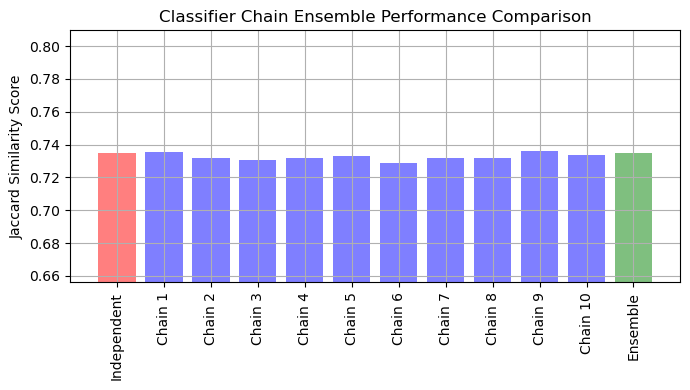

In [55]:
# plotting results
model_scores = [ovr_jaccard_score] + chain_jaccard_scores + [ensemble_jaccard_score]

model_names = (
    "Independent",
    "Chain 1",
    "Chain 2",
    "Chain 3",
    "Chain 4",
    "Chain 5",
    "Chain 6",
    "Chain 7",
    "Chain 8",
    "Chain 9",
    "Chain 10",
    "Ensemble",
)

x_pos = np.arange(len(model_names))

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title("Classifier Chain Ensemble Performance Comparison")
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation="vertical")
ax.set_ylabel("Jaccard Similarity Score")
ax.set_ylim([min(model_scores) * 0.9, max(model_scores) * 1.1])
colors = ["r"] + ["b"] * len(chain_jaccard_scores) + ["g"]
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

## this section is for metrics

In [49]:
import gc 
gc.collect()

21

In [50]:
predictions = model.predict(X_test)

[22:26:01] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:01] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:01] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:02] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:02] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:02] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:02] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/gbm/gbtree.cc:131: Using tree method: 0
[22:26:02] DEBUG: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/

In [51]:
predictions

<Compressed Sparse Column sparse matrix of dtype 'int64'
	with 4009 stored elements and shape (631, 14)>

In [154]:
Y_test

array([[0, 1, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 1]], shape=(339, 14))

# METRICS

In [27]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score

In [28]:
def metrics(Y_test, predictions):
    print (f"accuracy: {accuracy_score(Y_test, predictions)}")
    print ("---------------------------")
    print (f"macro f1 score: {f1_score(Y_test, predictions, average='macro')}")
    print (f"macro recall score: {recall_score(Y_test, predictions, average='macro')}")
    print (f"macro precision score: {precision_score(Y_test, predictions, average='macro')}")
    print ("---------------------------")
    print (f"weighted f1 score: {f1_score(Y_test, predictions, average='weighted')}")
    print (f"Weighted recall score: {recall_score(Y_test, predictions, average='weighted')}")
    print (f"weighted precision score: {precision_score(Y_test, predictions, average='weighted')}")
    

In [52]:
metrics(Y_test, predictions.toarray())

accuracy: 0.1347068145800317
---------------------------
macro f1 score: 0.5844864185147907
macro recall score: 0.5781651616130599
macro precision score: 0.6097563875586572
---------------------------
weighted f1 score: 0.8362920712777616
Weighted recall score: 0.8578040627410646
weighted precision score: 0.8275883302539694


/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

In [35]:
metrics(Y_test, predictions.toarray())

accuracy: 0.13153724247226625
---------------------------
macro f1 score: 0.5583476748738755
macro recall score: 0.5577796726096763
macro precision score: 0.5684750378081562
---------------------------
weighted f1 score: 0.8356138794096653
Weighted recall score: 0.8549461814454126
weighted precision score: 0.8255650011038281


/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/news_project/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capit

In [ ]:
joblib.dump(classifier, 'data/news_classifier.pkl')

['data/news_classifier.pkl']

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
texts=X_train.text

# Create a TextVectorization layer
vectorizer = tf.keras.layers.TextVectorization(max_tokens=100, output_mode='int', output_sequence_length=10)

# Adapt the layer to the text data
vectorizer.adapt(texts)

# Tokenize and preprocess the text data
processed_data = vectorizer(texts)

# Get the vocabulary and tokenized sequences
vocabulary = vectorizer.get_vocabulary()
tokenized_sequences = processed_data.numpy()

# Print the processed data, vocabulary, and tokenized sequences
print("Processed Data:")
print(processed_data)

print("\nVocabulary:")
print(vocabulary)

print("\nTokenized Sequences:")
print(tokenized_sequences)